In [1]:
from cgeval import Report
from cgeval.report import GenericReport
from cgeval.distribution import Beta

from collections import Counter
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.stats import beta


In [2]:
MODEL = {
    'llama 2': '../../out/pipeline/2025-06-25_sentiment_llama2',
}


In [3]:
def load_reports(cfg, base_path):
    reports = []

    for classifier in cfg.classifier:
        report = GenericReport()
        report.load(f"{base_path}/quantify/cls_report_{classifier.id}.json")
        reports.append(report)

    return reports

@dataclass(frozen=True)
class BetaParams:
    a: float
    b: float

    def __post_init__(self):
        if self.a < 0.:
            raise ValueError(f"parameter `a` of Beta distribution need to be > 0")
        if self.b < 0.:
            raise ValueError(f"parameter `b` of Beta distribution need to be > 0")


def fit_beta(samples: np.ndarray[float]) -> BetaParams:
    mu = np.mean(samples)
    var = np.var(samples)

    total_evidence = ((mu * (1. - mu)) / var) - 1.  # a + b

    a = mu * total_evidence
    b = (1. - mu) * total_evidence

    return BetaParams(a=a, b=b)

In [5]:
for id, base_path in MODEL.items():
    cfg = OmegaConf.load(f"{base_path}/config.yaml")
    reports = load_reports(cfg, base_path)
    break


In [6]:
# oracle_rating_samples = np.array(vars(reports[0])['report']['match']['oracle_ratings'])
# sorted(Counter(oracle_rating_samples).items())[0][1]
# dist = fit_beta(oracle_rating_samples)

# mean, var, skew, kurt = beta.stats(dist.a, dist.b, moments='mvsk')

# (mean, var, skew, kurt)

# (dist.a, dist.b)

In [6]:

from prettytable import PrettyTable

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)

def get_mode(a,b):
    if a > 1 and b > 1:
        mode = (a - 1) / (a + b - 2)
    else:
        mode = 0 if a < 1 and b >= 1 else 1 
    return mode

def plot_oracle(ax, dist):
    a = dist.params.a
    b = dist.params.b

    x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
    pdf = beta.pdf(x, a, b)
    line, = ax.plot(x, pdf, color='orange', lw=1, alpha=.8, label='Human')
    ax.fill_between(x, pdf, color=line.get_color(), alpha=0.1)

    mode = get_mode(a, b)
    ax.axvline(mode, color=line.get_color(), linestyle='--', lw=1)


def plot_beta(ax, samples, label):
    dist = fit_beta(samples)

    x = np.linspace(beta.ppf(0.01, dist.a, dist.b), beta.ppf(0.99, dist.a, dist.b), 100)
    pdf = beta.pdf(x, dist.a, dist.b)
    line, = ax.plot(x, pdf, lw=1, alpha=.8, label=label)
    ax.fill_between(x, pdf, color=line.get_color(), alpha=0.1)

    mode = get_mode(dist.a, dist.b)
    ax.axvline(mode, color=line.get_color(), linestyle='--', lw=1)

def plot_binary(reports: list[Report], classifiers, field, title):
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)

    fig = plt.figure(figsize=(8, 4))

    ax_1 = fig.add_subplot(1, 1, 1)
    ax_1.set_title(title)
    ax_1.set_ylim(0,100)

    # oracle_rating_samples = np.array(vars(reports[0])['report']['match']['oracle_ratings'])
    # oracle_rating_samples = np.array(vars(reports[0])['report']['count_match']['oracle_ratings'])
    # oracle_rating_samples = np.array(vars(reports[0])['report']['animal_match']['oracle_ratings'])

    oracle_dist = vars(reports[0])['dist_report'][0]
    oracle_dist = Beta(params=BetaParams(oracle_dist['a'],oracle_dist['b']))

    plot_oracle(ax_1, oracle_dist)

    for idx, re in enumerate(reports):
        plot_beta(ax_1, re.samples[field], f'{classifiers[idx].id}')

    # fig.legend(loc='upper right', title='Legend', bbox_to_anchor=(1.15, 0.85))
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85))
    return fig


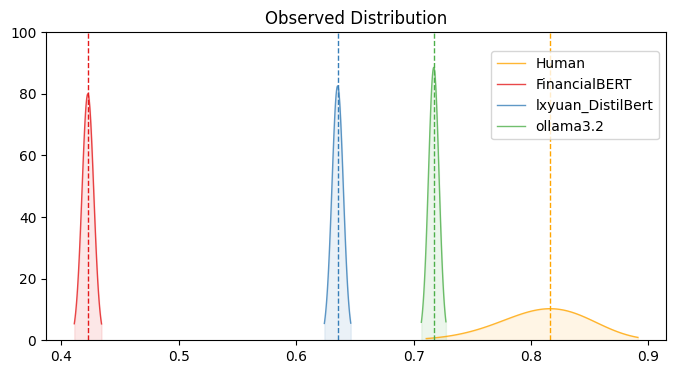

In [7]:
fig_obs = plot_binary(reports, cfg.classifier, 'alpha_obs', 'Observed Distribution')

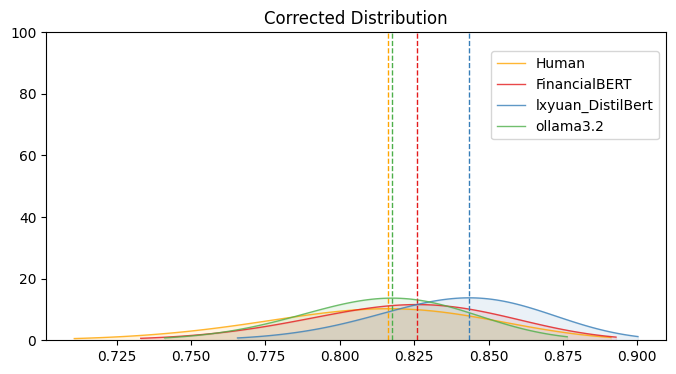

In [8]:
fig = plot_binary(reports, cfg.classifier, 'alpha', 'Corrected Distribution')

FinancialBERT 2.452314127597633e-05
lxyuan_DistilBert 2.3451794439266843e-05
ollama3.2 2.0343992764690898e-05


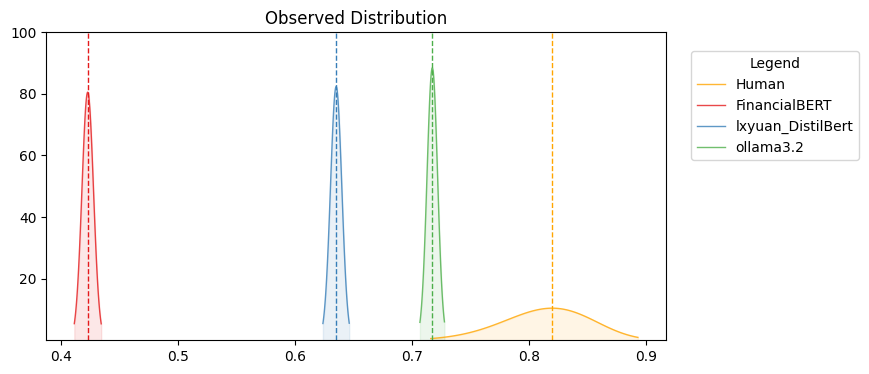

In [172]:
fig = plt.figure(figsize=(8, 4))

ax_1 = fig.add_subplot(1, 1, 1)
ax_1.set_title('Observed Distribution')
ax_1.set_ylim(0.01,100)
# ax_1.set_xlim(0.01,1)

oracle_rating_samples = np.array(vars(reports[0])['report']['match']['oracle_ratings'])
plot_oracle(ax_1, oracle_rating_samples)

for idx, re in enumerate(reports):
    samples = re.samples['alpha']
    cls = cfg.classifier[idx]

    plot_beta(ax_1, re.samples['alpha_obs'], f'{cls.id}')

# plt.legend(loc='upper right', title='Legend', bbox_to_anchor=(1.05, 1))
fig.legend(loc='upper right', title='Legend', bbox_to_anchor=(1.15, 0.85))
plt.show()


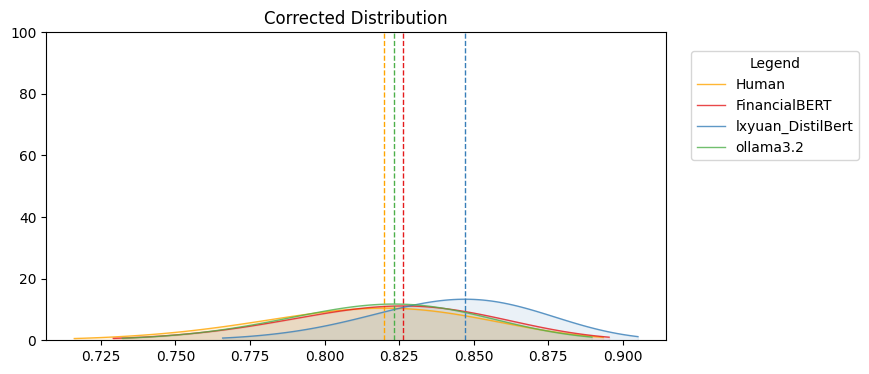

In [8]:
fig = plt.figure(figsize=(8, 4))

ax_2 = fig.add_subplot(1, 1, 1)
ax_2.set_title('Corrected Distribution')
ax_2.set_ylim(0,100)
# ax_2.set_xlim(0,1)


oracle_rating_samples = np.array(vars(reports[0])['report']['match']['oracle_ratings'])
plot_oracle(ax_2, oracle_rating_samples)

for idx, re in enumerate(reports):
    samples = re.samples['alpha']
    cls = cfg.classifier[idx]

    plot_beta(ax_2, re.samples['alpha'], f'{cls.id}')

fig.legend(loc='upper right', title='Legend', bbox_to_anchor=(1.15, 0.85))
plt.show()


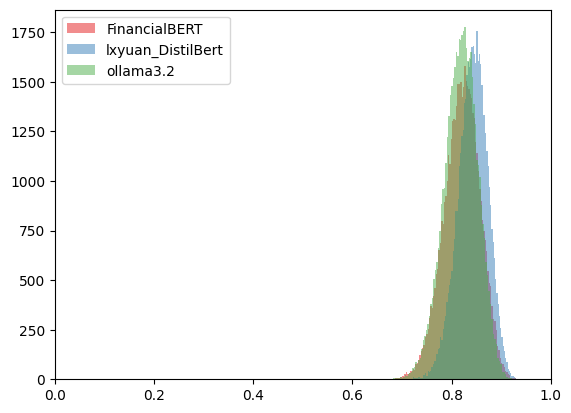

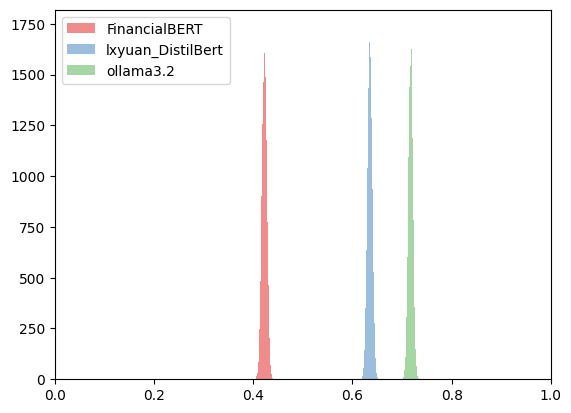

In [9]:
def plot_sampels(reports: list[Report], classifiers, field = 'alpha'):
    # plt.title(title)

    for idx, cls in enumerate(reports):
        samples = cls.samples[field]
        cls = classifiers[idx]
        plt.hist(samples, bins=100, alpha=.5, linewidth=0, label=f'{cls.id}')

    plt.xlim(0, 1)

    # plt.axvline(x = 0.35, alpha=.5, color = 'b', label = 'positive_input')
    # plt.axvline(x = 0.3, alpha=.5, color = 'r', label = 'neutral_input')
    # plt.axvline(x = 0.345, alpha=.5, color = 'g', label = 'negative_input')

    plt.legend()
    plt.show()

plot_sampels(reports, cfg.classifier)
plot_sampels(reports, cfg.classifier, 'alpha_obs')